
<a id='perm-income-cons'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Poupança Ótima II: Técnicas QL


<a id='index-1'></a>

## Conteúdo

- [Poupança Ótima II: Técnicas QL](#Poupança-Ótima-II:-Técnicas-QL)  
  - [Resumo](#Resumo)  
  - [Introdução](#Introdução)  
  - [A Aproximação QL](#A-Aproximação-QL)  
  - [Implementação](#Implementação)  
  - [Dois Exemplos de Poupança](#Dois-Exemplos-de-Poupança)  

> *Devidamente traduzido, revisado e adaptado do [QuantEcon](https://quantecon.org/) pelos bolsistas CNPq, Pedro Luiz H. Furtado e Jonas Aragão M. Corpes, sob supervisão do Prof. Christiano Penna, do CAEN/UFC.*

Co-authored with Chase Coleman.

## Resumo

Esta aula continua nossa análise do modelo de renda permanente quadrática-linear (QL) de economia e consumo.

Como vimos em nossa [aula anterior](https://julia.quantecon.org/perm_income.html) sobre esse tópico, Robert Hall [Hal78](https://julia.quantecon.org/../zreferences.html#hall1978) utilizou o modelo de renda permanente QL para restringir e interpretar melhoramentos intertemporais de consumo não durável, renda não financeira e riqueza financeira.

Por exemplo, vimos como o modelo afirma que, para qualquer processo estacionário de covariância para receita não financeira:

- o consumo é uma caminhada aleatória
- a riqueza financeira tem uma raiz unitária e é cointegrada com o consumo


Outros aplicativos usam a mesma estrutura QL.

Por exemplo, um modelo isomórfico para o modelo de renda permanente QL foi usado por Robert Barro [Bar79](https://julia.quantecon.org/../zreferences.html#barro1979) para interpretar alterações intertemporais de um governo cobrança de impostos, suas despesas líquidas do serviço da dívida e sua dívida pública.

Esse isomorfismo significa que, ao analisar o modelo de renda permanente QL, estamos analisando também o modelo de suavização de impostos de Barro.

É apenas uma questão de redefinir adequadamente as variáveis no modelo de Hall.

Nesta aula, vamos:

- Mostrar como a solução para o modelo de renda permanente QL pode ser obtida usando métodos de controle QL.
- Representar o modelo como um sistema linear de espaço de estados, como [nesta aula](https://julia.quantecon.org/../tools_and_techniques/linear_models.html), e
- Aplicar o tipo [LSS] do [QuantEcon](http://quantecon.org/quantecon-jl)(https://github.com/QuantEcon/QuantEcon.jl/blob/master/src/lss.jl) ao explicar as características estatísticas dos planos ótimos de consumo e empréstimos do consumidor.


Em seguida, usaremos essas caracterizações para construir um modelo simples de riqueza e
dinâmica de consumo no espírito de Truman Bewley [Bew86](https://julia.quantecon.org/../zreferences.html#bewley86).

(Mais tarde, estudaremos outros modelos de Bewley - consulte [esta palestra](https://julia.quantecon.org/../multi_agent_models/aiyagari.html)

O modelo será útil para ilustrar conceitos como:

- estacionariedade.
- ergodicidade.
- momentos do conjunto e observações de seção transversal.  

### Configuração

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0")
# github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0", instantiate = true) # uncomment to force package installation

In [2]:
using LinearAlgebra, Statistics

## Introdução

Vamos relembrar as características básicas do [modelo de renda permanente](https://julia.quantecon.org/perm_income.html).

As preferências do consumidor são ordenadas por:


<a id='equation-old1'></a>
$$
E_0 \sum_{t=0}^\infty \beta^t u(c_t) \tag{1}
$$

onde $ u(c) = -(c - \gamma)^2 $.

O consumidor maximiza [(1)](#equation-old1) pela escolha do consumo, planejando emprestar $ \{c_t, b_{t+1}\}_{t=0}^\infty $
sujeito à sequência de restrições orçamentárias:


<a id='equation-old2'></a>
$$
c_t + b_t = \frac{1}{1 + r} b_{t+1}  + y_t,
\quad t \geq 0 \tag{2}
$$

e à condição de no-Ponzi:


<a id='equation-old42'></a>
$$
E_0 \sum_{t=0}^\infty \beta^t b_t^2 < \infty \tag{3}
$$

A interpretação de todas as variáveis e parâmetros é a mesma que na
[aula anterior](https://julia.quantecon.org/perm_income.html).

Continuamos assumindo que $ (1 + r) \ beta = 1 $.

A dinâmica de $ \{y_t\} $ segue novamente o modelo linear de espaço de estados


<a id='equation-sprob15ab2'></a>
$$
\begin{aligned}
    z_{t+1} & = A z_t + C w_{t+1}
    \\
    y_t & = U  z_t
\end{aligned} \tag{4}
$$

As restrições no processso de choque e parâmetros são as mesmas da nossa [aula passada](https://julia.quantecon.org/perm_income.html).

### Digressão em um isomorfismo útil

O modelo de consumo permanente QL é matematicamente isomórfico com uma versão do modelo de suavização de impostos de Barro [Bar79](https://julia.quantecon.org/../zreferences.html#barro1979).

No modelo de renda permanente QL:

- A família enfrenta um processo exógeno de renda não financeira, e
- A família quer suavizar o consumo entre estados e tempo.


No modelo de suavização de impostos de Barro:

- Um governo enfrenta uma sequência exógena de compras do governo (líquido dos pagamentos de juros de sua dívida), e
- Um governo quer suavizar a cobrança de impostos nos estados e no tempo.


Se definirmos;

- $ T_t $, como a arrecadação total de impostos no modelo de Barro para consumo $ c_t $ no modelo de renda permanente QL;  
- $ G_t $, como as despesas governamentais exógenas no modelo de Barro para receita não financeira $ y_t $ no modelo de renda permanente;  
- $ B_t $, como os ativos governamentais de um período livres de risco que vencem no modelo de Barro e dívida do consumidor livre de risco de $ b_t $ com vencimento no modelo de renda permanente QL, e 
- $ R $, como a taxa bruta de retorno da dívida pública de um período sem risco no modelo de Barro com a taxa bruta de retorno de $ 1 + r $ em ativos financeiros no modelo de renda permanente de consumo.  


então, os dois modelos são equivalentes.

Todas as caracterizações de $ \{c_t, y_t, b_t \} $  no modelo de renda permanente QL se aplicam automaticamente a um processo $ \{T_t, G_t, B_t\} $ no modelo de Barro de suavização de impostos.

Consulte [modelos de suavização de consumo e tributação](https://julia.quantecon.org/smoothing.html) para explorar ainda mais um isomorfismo entre modelos de suavização de consumo e tributação.

### Uma especificação para o processo de renda não-financeira

Para os propósitos dessa aula, vamos assumir que $ \{y_t\} $ é um processo autoregressivo univariado de segunda ordem:

$$
y_{t+1} = \alpha + \rho_1 y_t + \rho_2 y_{t-1} + \sigma w_{t+1}
$$

Podemos mapear isso na estrutura linear do espaço de estados em [(4)](#equation-sprob15ab2), como foi discutido na nossa aula de [modelos lineares](https://julia.quantecon.org/../tools_and_techniques/linear_models.html).

Para isso, tomamos:

$$
z_t =
\begin{bmatrix}
    1 \\
    y_t \\
    y_{t-1}
\end{bmatrix},
\quad
A = \begin{bmatrix}
          1 & 0 & 0 \\
          \alpha & \rho_1 & \rho_2  \\
          0 & 1 & 0
    \end{bmatrix},
\quad
C= \begin{bmatrix}
    0 \\
    \sigma \\
    0
    \end{bmatrix},
\quad \text{e} \quad
U = \begin{bmatrix} 0 & 1 & 0 \end{bmatrix}
$$

## A Aproximação QL

[Anteriormente](https://julia.quantecon.org/perm_income.html#odr-pi), resolvemos o modelo de renda permanente resolvendo um sistema de equações lineares de diferença esperada sujeitas a duas condições de contorno.

Aqui, resolvemos o mesmo modelo usando [métodos LQ](https://julia.quantecon.org/lqcontrol.html) com base em programação dinâmica.

Depois de confirmar que as respostas produzidas pelos dois métodos concordam, aplicamos o dígito [LSS](https://github.com/QuantEcon/QuantEcon.jl/blob/master/src/lss.jl) de [QuantEcon](http://quantecon.org/quantecon-jl)
para ilustrar os recursos do modelo.

Por que resolver um modelo de duas maneiras distintas?

Porque, ao fazer isso, reunimos informações sobre a estrutura do modelo.

Nossa abordagem anterior, baseada na solução de um sistema de equações de diferença de expectativa, trouxe à tona o papel das expectativas do consumidor em relação a renda não financeira futura.

Por outro lado, formular o modelo em termos de um problema de programação dinâmica QL nos lembra que:

- Encontrar o estado (de um problema de programação dinâmica) é uma arte, e
- Iterações em uma equação de Bellman implicitamente resolvem conjuntamente um problema de previsão e um problema de controle.  

### O problema QL

Lembre-se da nossa [aula sobre a teoria QL](https://julia.quantecon.org/lqcontrol.html) que o problema ideal do regulador linear é escolher uma regra de decisão para $ u_t $ para minimizar:

$$
\mathbb E
\sum_{t=0}^\infty \beta^t \{x'_t R x_t+ u'_t Q u_t\},
$$

sujeito à $ x_0 $ dado e à lei da moção:


<a id='equation-pilqsd'></a>
$$
x_{t+1} =  \tilde A x_t+ \tilde B u_t+ \tilde C w_{t+1},
\qquad t\geq 0, \tag{5}
$$

onde $ w_{t+1} $ é iid com vetor-média zero e $ \mathbb E w_t w'_t= I $.

Os acentos em $ \tilde A, \tilde B, \tilde C $ são para evitar confusão com a notação em [(4)](#equation-sprob15ab2).

A função valor para esse problema é $ v(x) = - x'Px - d $, onde:

- $ P $ é a única solução positiva semidefinida da [equação matricial de Riccati correspondente](https://julia.quantecon.org/lqcontrol.html#riccati-equation);  
- O escalar $ d $ é dado por $ d=\beta (1-\beta)^{-1} {\rm trace} ( P \tilde C \tilde C') $.  


A política ótima é dada por $ u_t = -Fx_t $, onde $ F := \beta (Q+\beta \tilde B'P \tilde B)^{-1} \tilde B'P \tilde A $.

Sob uma regra de decisão ótima $ F $, o vetor de estado $ x_t $ evolui de acordo com $ x_{t+1} = (\tilde A-\tilde BF) x_t + \tilde C w_{t+1} $.

### Mapeando a estrutura QL

Para mapear a estrutura Ql, usaremos:

$$
x_t :=
    \begin{bmatrix}
        z_t \\
        b_t
    \end{bmatrix}
    =
    \begin{bmatrix}
        1 \\
        y_t \\
        y_{t-1} \\
        b_t
    \end{bmatrix}
$$

como vetor de estado e $ u_t := c_t - \gamma $ como de controle.

Com essa notação e $ U_\gamma := \begin{bmatrix} \gamma & 0 & 0 \end{bmatrix} $, nós podemos escrever a dinâmica de estado como em [(5)](#equation-pilqsd) quando:

$$
\tilde A :=
     \begin{bmatrix}
        A  &  0 \\
        (1 + r)(U_\gamma - U) & 1 + r
     \end{bmatrix}
\quad
\tilde B :=
   \begin{bmatrix}
   0 \\
   1 + r
   \end{bmatrix}
\quad \text{and} \quad
\tilde C :=
   \begin{bmatrix}
   C \\ 0
   \end{bmatrix}
   w_{t+1}
$$

Confirme por si mesmo que, com essas definições, a dinâmica QL [(5)](#equation-pilqsd) corresponde à dinâmica de $ z_t $ e $ b_t $ descrita acima.

Para mapear a utilidade no formato quadrático $ x_t 'R x_t + u_t'Q u_t $, podemos definir:
- $ Q := 1 $ (lembre-se que estamos minimizando),d e  
- $ R := $ uma matriz de zeros $ 4 \times 4 $.  


Porém, ainda há um problema.

Não temos uma maneira direta de capturar a restrição não recursiva [(3)](#equation-old42)
na sequência da dívida $ \{b_t\} $ na estrutura do QL.

Para tentar aplicá-lo, usaremos um truque: aplique uma pequena penalidade em $ b_t^2 $ na função de critério.

Na configuração atual, isso significa adicionar uma pequena entrada $ \epsilon> 0 $ na posição $ (4,4) $ de $ R $.

Isso induzirá (espero) um pequeno erro de aproximação na regra de decisão.

Vamos verificar se realmente é pequeno numericamente em breve.

## Implementação

Vamos escrever um código para resolver o modelo.

Um comentário antes de começarmos é que o nível de felicidade do consumo $ \gamma $ na função de utilidade não afeta a regra de decisão ideal.

Vimos isso na aula anterior, sobre [renda permanente](https://julia.quantecon.org/perm_income.html).

O motivo é que ele sai da equação de Euler para consumo.

A seguir, definimos o valor igual a unidade.

### O proesso exógeno de renda não-financeira

Primeiro, nós criamos o objeto para o regulador linear ótimo:

In [3]:
using QuantEcon, LinearAlgebra
using Plots
gr(fmt=:png);

# Configurar parâmetros
α, β, ρ1, ρ2, σ = 10.0, 0.95, 0.9, 0.0, 1.0

R = 1 / β
A = [1.0 0.0 0.0;
       α  ρ1  ρ2;
    0.0 1.0 0.0]
C = [0.0; σ; 0.0]''
G = [0.0 1.0 0.0]

# Formular o sistema linear de espaço de estado e retirar os momentos de estado estacionário:
μ_z0 = [1.0, 0.0, 0.0]
Σ_z0 = zeros(3, 3)
Lz = LSS(A, C, G, mu_0=μ_z0, Sigma_0=Σ_z0)
μ_z, μ_y, Σ_z, Σ_y = stationary_distributions(Lz)

# Vetor médio de estado para o problema da economia:
mxo = [μ_z; 0.0]

# Criar a matriz de covariância estacionária de x -- todos começam em b=0
a1 = zeros(3, 1)
aa = hcat(Σ_z, a1)
bb = zeros(1, 4)
sxo = vcat(aa, bb)

# Essas escolhas inicializarão o vetor de estado de um indivíduo com dívida zero
# e a distribuição ergódica do processo de doação. Use-os para criar
# a economia de Bewley.
mxbewley = mxo
sxbewley = sxo

4×4 Array{Float64,2}:
 0.0  0.0      0.0      0.0
 0.0  5.26316  4.73684  0.0
 0.0  4.73684  5.26316  0.0
 0.0  0.0      0.0      0.0

O próximo passo é criar as matrizes para o sistema QL:

In [4]:
A12 = zeros(3,1)
ALQ_l = hcat(A, A12)
ALQ_r = [0 -R 0 R]
ALQ = vcat(ALQ_l, ALQ_r)

RLQ = [0.0 0.0 0.0 0.0;
        0.0 0.0 0.0 0.0;
        0.0 0.0 0.0 0.0;
        0.0 0.0 0.0 1e-9]

QLQ = 1.0
BLQ = [0.0; 0.0; 0.0; R]
CLQ = [0.0; σ; 0.0; 0.0]
β_LQ = β

0.95

Vamos imprimi-los e dar uma olhada neles.

In [5]:
println("A = $ALQ")
println("B = $BLQ")
println("R = $RLQ")
println("Q = $QLQ")

A = [1.0 0.0 0.0 0.0; 10.0 0.9 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 -1.0526315789473684 0.0 1.0526315789473684]
B = [0.0, 0.0, 0.0, 1.0526315789473684]
R = [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0e-9]
Q = 1.0


Agora crie a instância apropriada de um modelo QL:

In [6]:
LQPI = QuantEcon.LQ(QLQ, RLQ, ALQ, BLQ, CLQ, bet=β_LQ);

Em breve, salvaremos a função política implícita ideal e compararemos com o que obtemos
empregando um método de solução alternativo.

In [7]:
P, F, d = stationary_values(LQPI)    #  computar a função valor e a regra de decisão
ABF = ALQ - BLQ * F    #  formular o sistema de circuito fechado

4×4 Array{Float64,2}:
  1.0      0.0       0.0  0.0
 10.0      0.9       0.0  0.0
  0.0      1.0       0.0  0.0
 68.9655  -0.689655  0.0  1.0

### Comparação com a aproximação de equações à diferenças

Em nossa [primeira aula](https://julia.quantecon.org/perm_income.html) no horizonte infinito permanente
problema de renda, usamos um método de solução diferente.

O método foi baseado em torno de:

- Deduzir as equações de Euler que são as condições de primeira ordem em relação ao consumo e economia;
- Usar as restrições orçamentárias e a condição de contorno para concluir um sistema de equações de diferença linear esperada;
- Resolver essas equações para obter a solução.


Expressada em notação de espaço de estado, a solução assumiu a forma:

$$
\begin{aligned}
    z_{t+1} & = A z_t + C w_{t+1} \\
    b_{t+1} & = b_t + U [ (I -\beta A)^{-1} (A - I) ] z_t \\
        y_t & = U z_t \\
        c_t & = (1-\beta) [ U (I-\beta A)^{-1} z_t - b_t ]
\end{aligned}
$$

Agora vamos aplicar as fórmulas neste sistema.

In [8]:
# Use as fórmulas acima para criar as políticas ideais para b_ {t + 1} e c_t
b_pol = G * (inv(I - β * A)) * (A - I)
c_pol = (1 - β) * (G * inv(I - β * A))

# Criar a matriz A para a instância do espaço de estado linear
A_LSS1 = vcat(A, b_pol)
A_LSS2 = [0, 0, 0, 1]
A_LSS = hcat(A_LSS1, A_LSS2)

# Criar a matriz C para os modelos LSS
C_LSS = vcat(C, 0)

# Criar a matriz G para os modelos LSS
G_LSS1 = vcat(G, c_pol)
G_LSS2 = vcat(0, -(1 - β))
G_LSS = hcat(G_LSS1, G_LSS2)

# Use os seguintes valores para iniciar todos com b = 0, renda inicial zero
μ_0 = [1.0, 0.0, 0.0, 0.0]
Σ_0 = zeros(4, 4)

4×4 Array{Float64,2}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

A_LSS calculado como temos aqui deve ser igual a ABF calculado acima usando o modelo QL.

In [9]:
ABF - A_LSS

4×4 Array{Float64,2}:
  0.0         0.0         0.0   0.0   
  0.0         0.0         0.0   0.0   
  0.0         0.0         0.0   0.0   
 -9.51248e-6  9.51248e-8  0.0  -2.0e-8

Agora compare os elementos pertinentes de c_pol e F.

In [10]:
println(c_pol, -F)

[65.51724137931033 0.34482758620689685 0.0][65.51723234245394 0.344827676575457 -0.0 -0.050000018999992145]


Verificamos que os dois métodos fornecem a mesma solução.

Agora vamos criar instâncias do tipo [LSS](https://github.com/QuantEcon/QuantEcon.jl/blob/master/src/lss.jl) e usá-lo para fazer algumas experiências interessantes.

Para fazer isso, usaremos os resultados do nosso segundo método.

## Dois Exemplos de Poupança

No espírito dos modelos Bewley [Bew86](https://julia.quantecon.org/../zreferences.html#bewley86), geraremos painéis de consumidores.

Os exemplos diferem apenas nos estados iniciais com os quais damos aos consumidores.

Todos os outros valores de parâmetro são mantidos iguais nos dois exemplos.

- No primeiro exemplo, todos os consumidores começam com zero receita não financeira e zero dívida.
  
  - Os consumidores são *ex ante* idênticos.
  
- No segundo exemplo, enquanto todos começam com dívida zero, extraímos seus níveis de renda inicial da distribuição invariável de receita financeira.
  
  - Os consumidores são *ex ante* heterogêneos.
  


No primeiro exemplo, os caminhos de receita não financeira dos consumidores são exibidos
transitórios pronunciados no início da amostra.

- Isso afetará os resultados de maneira impressionante.


Esses efeitos transitórios não estarão presentes no segundo exemplo.

Usamos métodos afiliados ao tipo [LSS](https://github.com/QuantEcon/QuantEcon.jl/blob/master/src/lss.jl) para simular o modelo.

### Primeiro conjunto de condições iniciais

Geramos 25 caminhos do processo de receita não financeira exógena e os caminhos ótimos associados de consumo e dívida.

Em um primeiro conjunto de gráficos, as linhas mais escuras representam um caminho de amostra específico, enquanto as linhas mais claras descrevem outros 24 caminhos.

Um segundo gráfico plota uma coleção de simulações em relação à distribuição da população que extraímos da instância LSS LSS.

Comparar caminhos de amostra com distribuições de população em cada data $ t $ é um exercício útil - consulte [nossa discussão](https://julia.quantecon.org/../tools_and_techniques/lln_clt.html#lln-mr) sobre as leis dos grandes números.

In [11]:
lss = LSS(A_LSS, C_LSS, G_LSS, mu_0=μ_0, Sigma_0=Σ_0);

### População e painéis simples

No código abaixo, usamos o tipo [LSS](https://github.com/QuantEcon/QuantEcon.jl/blob/master/src/lss.jl) para:

- Calcular e traçar quantis populacionais das distribuições de consumo e dívida para uma população de consumidores;
- Simular um grupo de 25 consumidores e traçar caminhos de amostra no mesmo gráfico como a distribuição da população.

In [12]:
function income_consumption_debt_series(A, C, G, μ_0, Σ_0, T = 150, npaths = 25)

    lss = LSS(A, C, G, mu_0=μ_0, Sigma_0=Σ_0)

    # simulação/momento dos parâmetros
    moment_generator = moment_sequence(lss)

    # simular caminhos variados
    bsim = zeros(npaths, T)
    csim = zeros(npaths, T)
    ysim = zeros(npaths, T)

    for i in 1:npaths
        sims = simulate(lss,T)
        bsim[i, :] = sims[1][end, :]
        csim[i, :] = sims[2][2, :]
        ysim[i, :] = sims[2][1, :]
    end

    # obter os momentos
    cons_mean = zeros(T)
    cons_var = similar(cons_mean)
    debt_mean = similar(cons_mean)
    debt_var = similar(cons_mean)
    for (idx, t) = enumerate(moment_generator)
        (μ_x, μ_y, Σ_x, Σ_y) = t
        cons_mean[idx], cons_var[idx] = μ_y[2], Σ_y[2, 2]
        debt_mean[idx], debt_var[idx] = μ_x[4], Σ_x[4, 4]
        idx == T && break
    end
    return bsim, csim, ysim, cons_mean, cons_var, debt_mean, debt_var
end

function consumption_income_debt_figure(bsim, csim, ysim)

    # obter T
    T =  size(bsim, 2)

    # criar uma primeira figura
    xvals = 1:T

    # plotar consumo e renda
    plt_1 = plot(csim[1,:], label="c", color=:blue, lw=2)
    plot!(plt_1, ysim[1, :], label="y", color=:green, lw=2)
    plot!(plt_1, csim', alpha=0.1, color=:blue, label="")
    plot!(plt_1, ysim', alpha=0.1, color=:green, label="")
    plot!(plt_1, title="Nonfinancial Income, Consumption, and Debt",
          xlabel="t", ylabel="y and c",legend=:bottomright)

    # plotar a dívida
    plt_2 = plot(bsim[1,: ], label="b", color=:red, lw=2)
    plot!(plt_2, bsim', alpha=0.1, color=:red,label="")
    plot!(plt_2, xlabel="t", ylabel="debt",legend=:bottomright)

    plot(plt_1, plt_2, layout=(2,1), size=(800,600))
end

function consumption_debt_fanchart(csim, cons_mean, cons_var,
                                   bsim, debt_mean, debt_var)
    # obter T
    T =  size(bsim, 2)

    # criar percentis de distribuições transversais
    cmean = mean(cons_mean)
    c90 = 1.65 * sqrt.(cons_var)
    c95 = 1.96 * sqrt.(cons_var)
    c_perc_95p, c_perc_95m = cons_mean + c95, cons_mean - c95
    c_perc_90p, c_perc_90m = cons_mean + c90, cons_mean - c90

    # criar percentis de distribuições transversais
    dmean = mean(debt_mean)
    d90 = 1.65 * sqrt.(debt_var)
    d95 = 1.96 * sqrt.(debt_var)
    d_perc_95p, d_perc_95m = debt_mean + d95, debt_mean - d95
    d_perc_90p, d_perc_90m = debt_mean + d90, debt_mean - d90

    xvals = 1:T

    # primeira classificação
    plt_1=plot(xvals, cons_mean, color=:black, lw=2, label="")
    plot!(plt_1, xvals, Array(csim'), color=:black, alpha=0.25, label="")
    plot!(xvals, fillrange=[c_perc_95m, c_perc_95p], alpha=0.25, color=:blue, label="")
    plot!(xvals, fillrange=[c_perc_90m, c_perc_90p], alpha=0.25, color=:red, label="")
    plot!(plt_1, title="Consumption/Debt over time",
          ylim=(cmean-15, cmean+15), ylabel="consumption")

    # segunda classificação
    plt_2=plot(xvals, debt_mean, color=:black, lw=2,label="")
    plot!(plt_2, xvals, Array(bsim'), color=:black, alpha=0.25,label="")
    plot!(xvals, fillrange=[d_perc_95m, d_perc_95p], alpha=0.25, color=:blue,label="")
    plot!(xvals, fillrange=[d_perc_90m, d_perc_90p], alpha=0.25, color=:red,label="")
    plot!(plt_2, ylabel="debt", xlabel="t")

    plot(plt_1, plt_2, layout=(2,1), size=(800,600))
end

consumption_debt_fanchart (generic function with 1 method)

Agora vamos criar figuras com as condições iniciais de zero para $ y_0 $ and $ b_0 $.

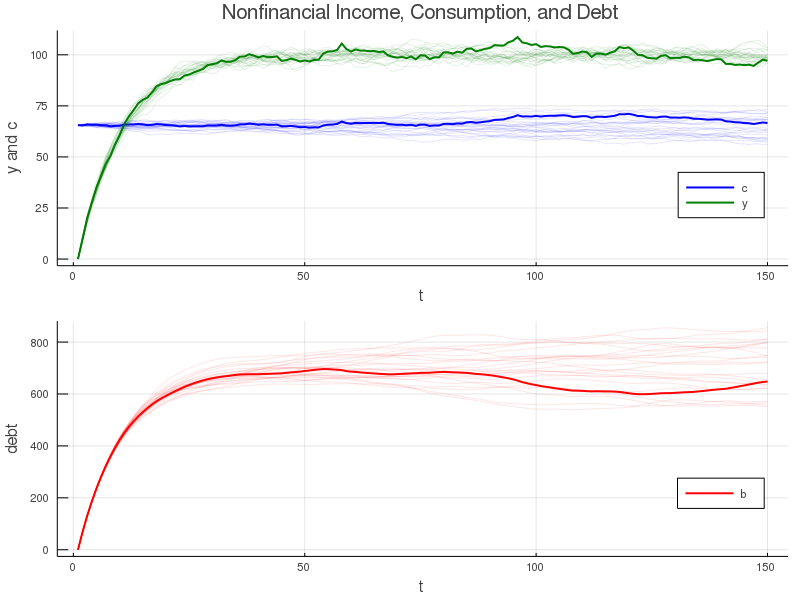

In [13]:
out = income_consumption_debt_series(A_LSS, C_LSS, G_LSS, μ_0, Σ_0)
bsim0, csim0, ysim0 = out[1:3]
cons_mean0, cons_var0, debt_mean0, debt_var0 = out[4:end]

consumption_income_debt_figure(bsim0, csim0, ysim0)

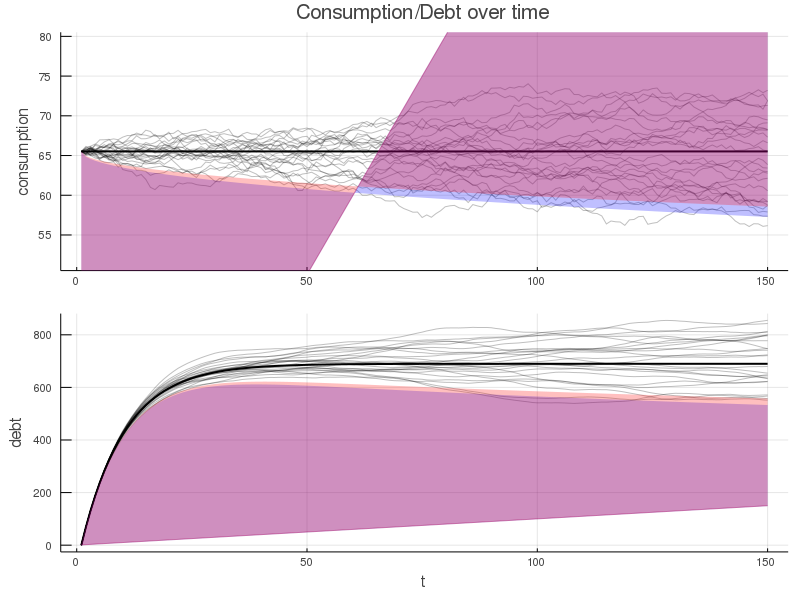

In [14]:
consumption_debt_fanchart(csim0, cons_mean0, cons_var0,
                          bsim0, debt_mean0, debt_var0)

Aqui está o que está acontecendo nos gráficos acima.

Para nossa simulação, definimos as condições iniciais $ b_0 = y _ {- 1} = y _ {- 2} = 0 $.

Como $ y _ {- 1} = y _ {- 2} = 0 $, a receita não financeira $ y_t $ começa muito abaixo da sua média estacionária $ \mu_ {y, \infty} $ e aumenta cedo em cada simulação.

Lembre-se da [aula anterior](https://julia.quantecon.org/perm_income.html) que podemos representar a regra de decisão ideal para o consumo em termos de **relação de co-integração**.


<a id='equation-old12'></a>
$$
(1-\beta) b_t + c_t = (1-\beta) E_t \sum_{j=0}^\infty \beta^j y_{t+j} \tag{6}
$$

Então, no tempo $ 0 $ nós temos:

$$
c_0 = (1-\beta) E_0 \sum_{t=0}^\infty \beta^j y_{t}
$$

Isso nos diz que o consumo começa com a renda que seria paga por uma anuidade cujo valor é igual ao valor descontado esperado da receita não financeira no momento $ t = 0 $.

Para suportar esse nível de consumo, o consumidor toma muito emprestado cedo e, consequentemente, cria dívidas substanciais.

De fato, ele ou ela contrai tantas dívidas que, eventualmente, no estado estacionário estocástico, consome menos a cada período do que sua renda não financeira.

Ele usa a diferença entre consumo e receita não financeira principalmente para atender aos pagamentos de juros devidos por sua dívida.

Assim, quando olhamos para o painel de dívida no gráfico a seguir, vemos que este é um grupo de pessoas idênticas *ex ante*, cada uma das quais começa com dívida zero.

Todos eles acumulam dívida em antecipação ao aumento da receita não financeira.

Eles esperam que sua renda não financeira suba em direção à distribuição invariante de renda, uma consequência de termos começado com $ y_{- 1} = y _{- 2} = 0 $.

#### Cointegração residual

A figura a seguir plota as realizações do lado esquerdo de [(6)](#equation-old12), que,
[como discutido em nossa última aula](https://julia.quantecon.org/perm_income.html#coint-pi), é chamado de **resíduo de cointegração**.

Como mencionado acima, o lado direito pode ser pensado como um pagamento de anuidade sobre o valor presente esperado da receita futura $ E_t \sum_ {j = 0} ^ \infty \beta ^ j y_ {t + j} $.

No início de uma realização, $ c_t $ é aproximadamente constante enquanto $ (1- \beta) b_t $ e $ (1- \beta) E_t \sum_{j = 0}^ \infty \beta^j y_{t + j} $ ambos aumentam acentuadamente como o valor presente da renda e o aumento dos empréstimos da família praticamente juntos.

Este exemplo ilustra o seguinte ponto: a definição de cointegração implica que o resíduo de cointegração seja
*assintoticamente* uma covariância estacionária, não *covariância estacionária*.

O resíduo cointegrante da especificação com receita zero e zero dívida inicialmente possui um componente transitório notável que domina sua comportamento no início da amostra.

Ao alterar as condições iniciais, removeremos esse transiente em nosso segundo exemplo a ser apresentado abaixo:

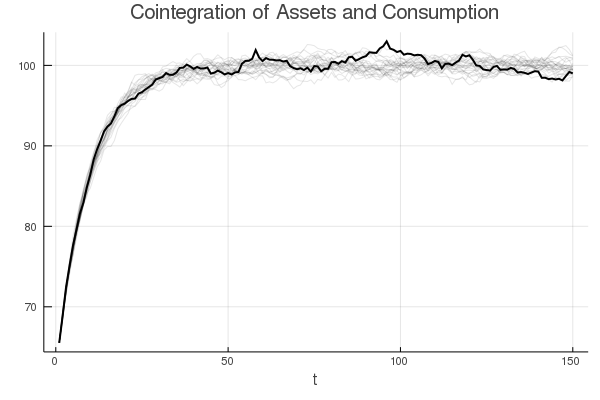

In [15]:
function cointegration_figure(bsim, csim)
    # criar a figura
    plot((1 - β) * bsim[1, :] + csim[1, :], color=:black,lw=2,label="")
    plot!((1 - β) * bsim' + csim', color=:black, alpha=.1,label="")
    plot!(title="Cointegration of Assets and Consumption", xlabel="t")
end

cointegration_figure(bsim0, csim0)

### Uma economia fechada com mutuários e credores

Quando configuramos $ y_{- 1} = y _{- 2} = 0 $ e $ b_0 = 0 $ no
No exercício anterior, endividamos "rumo ao norte" no início da amostra.

A dívida média na seção transversal aumenta e se aproxima da assíntota.

Podemos considerá-los como resultados de uma “pequena economia aberta” que
empréstimos do exterior à taxa bruta fixa de juros R $ = r + 1 $ em
antecipação do aumento da renda.

Assim, com as primitivas econômicas definidas acima, a economia converge para uma
estado estacionário em que existe um excesso de oferta agregada de produtos sem risco
empréstimos a uma taxa de juros bruta de R $.

Esse excesso de oferta é preenchido por “credores estrangeiros” dispostos a fazer esses empréstimos.

Podemos usar praticamente o mesmo código para manipular um modelo de "homem pobre de Bewley [Bew86](https://julia.quantecon.org/../zreferences.html#bewley86)" da seguinte maneira:

 - Como antes, começamos todos com $ b_0 = 0 $.
 - Mas, em vez de iniciar todos com $ y_{-1} = y_{-2} = 0 $, nós desenhamos $ \begin {bmatrix} e _{- 1} \\ y _{- 2} \end {bmatrix} $ da distribuição invariável do processo $ \{y_t \} $


Isso gera uma economia fechada na qual as pessoas estão pedindo e emprestando
a uma taxa bruta de juros livre de risco de
$ R = \beta^{- 1} $.

No grupo de pessoas analisadas, os empréstimos sem risco estão com excesso de oferta zero.

Organizamos primitivas para que $ R = \beta^{- 1} $ limpe o mercado de empréstimos sem risco com excesso de oferta agregada zero.

Portanto, os empréstimos sem risco estão sendo feitos de uma pessoa para outra dentro do nosso conjunto fechado de agentes.

Não há necessidade de empréstimos para o nosso grupo.

Vamos dar uma olhada nas figuras correspondentes:

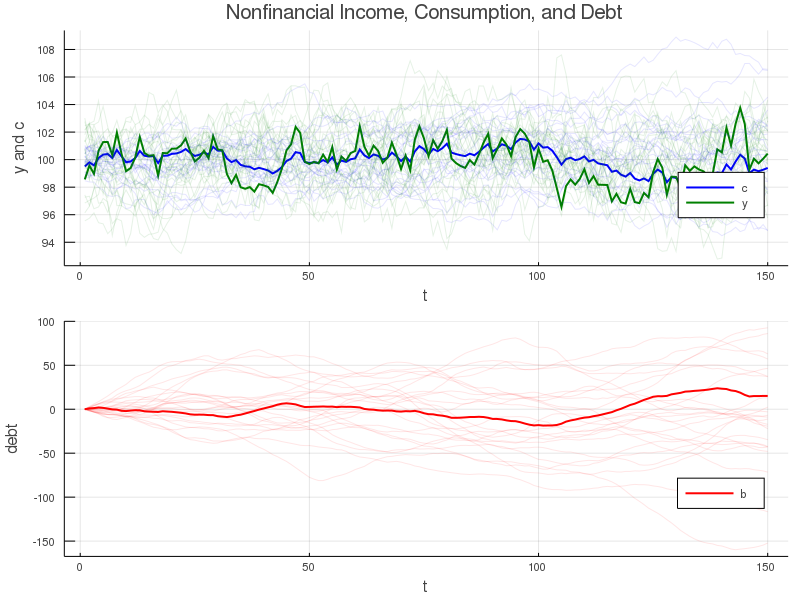

In [16]:
out = income_consumption_debt_series(A_LSS, C_LSS, G_LSS, mxbewley, sxbewley)
bsimb, csimb, ysimb = out[1:3]
cons_meanb, cons_varb, debt_meanb, debt_varb = out[4:end]

consumption_income_debt_figure(bsimb, csimb, ysimb)

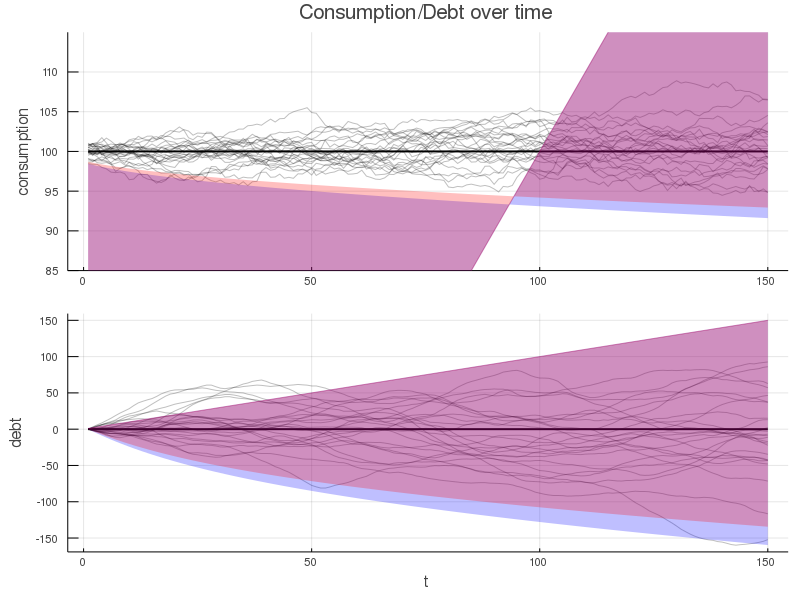

In [17]:
consumption_debt_fanchart(csimb, cons_meanb, cons_varb,
                          bsimb, debt_meanb, debt_varb)

Os gráficos confirmam os seguintes resultados:

- Como antes, a distribuição de consumo se espalha ao longo do tempo.


Mas agora há alguma dispersão inicial porque há heterogeneidade *ex ante* nos empates iniciais de $ \begin {bmatrix} y _ {- 1} \\ y _ {- 2} \end {bmatrix} $.

- Como antes, a distribuição transversal da dívida se espalha ao longo do tempo.
- Diferentemente de antes, o nível médio de dívida permanece em zero, confirmando que essa é uma economia fechada de tomadores de empréstimos e credores.
- Agora o resíduo cointegrante parece estacionário, e não apenas assintoticamente estacionário.


Vamos dar uma olhada na figura de cointegração:

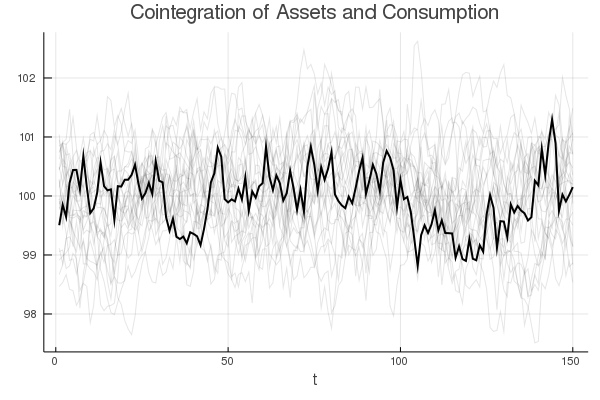

In [18]:
cointegration_figure(bsimb, csimb)